## Data Preparation

In [1]:
import zipfile
import pandas as pd
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Path to your zip file
zip_path = '../data/raw/MachineLearningRating_v3.zip'

# Path to the .txt file inside the extracted folder
txt_file = '../data/raw/MachineLearningRating_v3.txt'

# Check if the .txt file exists before extracting the zip file
if not os.path.exists(txt_file):
    # Extract the zip file if the .txt file does not exist
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('../data/raw')  # Extract to the raw data folder
else:
    print(f"The file {txt_file} already exists.")

# Load the data assuming pipe separator
df = pd.read_csv(txt_file, sep='|')

# Display the first few rows of the data to confirm it's loaded
print(df.head())

The file ../data/raw/MachineLearningRating_v3.txt already exists.


/tmp/ipykernel_2584535/1163968053.py:23: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(txt_file, sep='|')


   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCategory  \
0  Current account  ...             Mobility - 

### Handle Missing Data:

In [2]:
df.fillna(df.median(numeric_only=True), inplace=True)  # Impute missing numeric values with the median
df.fillna("Unknown", inplace=True)  # Replace missing categorical values with "Unknown"

/tmp/ipykernel_2584535/2939677815.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Unknown", inplace=True)  # Replace missing categorical values with "Unknown"


### One-Hot Encoding for Categorical Variables

In [3]:
onehot = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = pd.DataFrame(onehot.fit_transform(df[['Province', 'Gender']]))
encoded_cols.columns = onehot.get_feature_names_out(['Province', 'Gender'])

### Add encoded features back to the dataframe

In [4]:
df = df.join(encoded_cols)
df.drop(['Province', 'Gender'], axis=1, inplace=True)


### Feature Engineering: Example of creating new features

In [5]:
df['ClaimsPerPremium'] = df['TotalClaims'] / (df['TotalPremium'] + 1)  # Avoid division by zero

### Feature Scaling


In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Example DataFrame
# Ensure `df` is loaded and contains your data.

# Step 1: Identify non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object', 'datetime']).columns

# Step 2: Handle datetime columns
for col in non_numeric_columns:
    if pd.api.types.is_datetime64_any_dtype(df[col]):
        df[col] = pd.to_datetime(df[col]).apply(lambda x: x.timestamp())

# Step 3: Handle categorical columns
for col in non_numeric_columns:
    if not pd.api.types.is_datetime64_any_dtype(df[col]):
        df[col] = df[col].astype('category').cat.codes

# Step 4: Drop the target columns for scaling
target_columns = ['TotalPremium', 'TotalClaims']
features = df.drop(target_columns, axis=1)

# Step 5: Apply StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create a new DataFrame with scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

print(scaled_df.head())

   UnderwrittenCoverID  PolicyID  TransactionMonth  IsVATRegistered  \
0             0.638791  0.920659          0.011989        14.074932   
1             0.638791  0.920659          0.515853        14.074932   
2             0.638791  0.920659          1.019718        14.074932   
3             0.638886  0.920659          0.515853        14.074932   
4             0.638886  0.920659          1.019718        14.074932   

   Citizenship  LegalType     Title  Language      Bank  AccountType  ...  \
0     -0.34177    -2.0558 -0.198291       0.0 -0.703034    -0.688678  ...   
1     -0.34177    -2.0558 -0.198291       0.0 -0.703034    -0.688678  ...   
2     -0.34177    -2.0558 -0.198291       0.0 -0.703034    -0.688678  ...   
3     -0.34177    -2.0558 -0.198291       0.0 -0.703034    -0.688678  ...   
4     -0.34177    -2.0558 -0.198291       0.0 -0.703034    -0.688678  ...   

   Province_KwaZulu-Natal  Province_Limpopo  Province_Mpumalanga  \
0               -0.452192         -0.15958

### Train-Test Split

In [7]:
X = scaled_df
y_premium = df['TotalPremium']  # Target for predicting TotalPremium
y_claims = df['TotalClaims']  # Target for predicting TotalClaims
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_premium, test_size=0.3, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_claims, test_size=0.3, random_state=42)

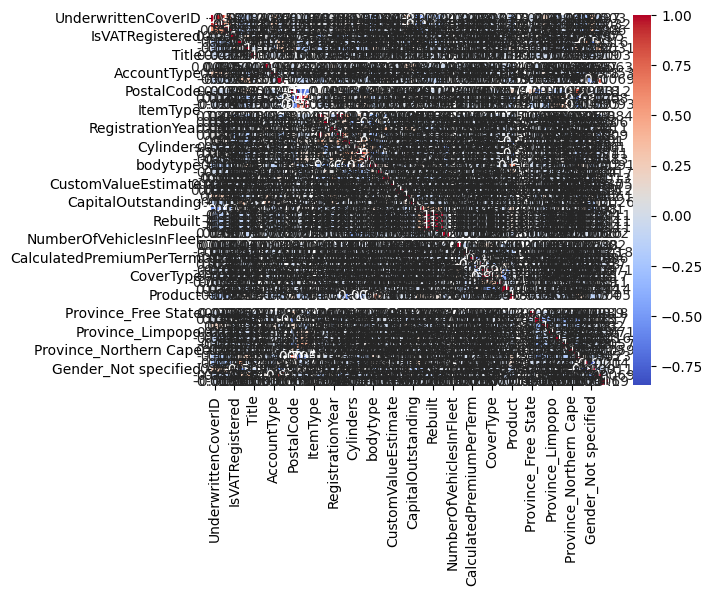

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
reduced_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
print(reduced_df.head())


        PC1       PC2
0 -1.472272  2.328526
1 -1.361444  2.262838
2 -1.250616  2.197150
3 -1.413782  2.180439
4 -1.302954  2.114751


## Model Building

### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression Model for TotalPremium
lr_p = LinearRegression()
lr_p.fit(X_train_p, y_train_p)
y_pred_p_lr = lr_p.predict(X_test_p)

# Linear Regression Model for TotalClaims
lr_c = LinearRegression()
lr_c.fit(X_train_c, y_train_c)
y_pred_c_lr = lr_c.predict(X_test_c)

### Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Model for TotalPremium
rf_p = RandomForestRegressor(random_state=42)
rf_p.fit(X_train_p, y_train_p)
y_pred_p_rf = rf_p.predict(X_test_p)

# Random Forest Model for TotalClaims
rf_c = RandomForestRegressor(random_state=42)
rf_c.fit(X_train_c, y_train_c)
y_pred_c_rf = rf_c.predict(X_test_c)


: 

### XGBoost

In [ ]:
from xgboost import XGBRegressor

# XGBoost Model for TotalPremium
xgb_p = XGBRegressor(random_state=42)
xgb_p.fit(X_train_p, y_train_p)
y_pred_p_xgb = xgb_p.predict(X_test_p)

# XGBoost Model for TotalClaims
xgb_c = XGBRegressor(random_state=42)
xgb_c.fit(X_train_c, y_train_c)
y_pred_c_xgb = xgb_c.predict(X_test_c)


## Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name, target_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - {target_name}:")
    print(f"  Mean Squared Error: {mse:.2f}")
    print(f"  Mean Absolute Error: {mae:.2f}")
    print(f"  R-squared: {r2:.2f}")
    print("-" * 50)

# Evaluate Models
evaluate_model(y_test_p, y_pred_p_lr, "Linear Regression", "TotalPremium")
evaluate_model(y_test_c, y_pred_c_lr, "Linear Regression", "TotalClaims")
evaluate_model(y_test_p, y_pred_p_rf, "Random Forest", "TotalPremium")
evaluate_model(y_test_c, y_pred_c_rf, "Random Forest", "TotalClaims")
evaluate_model(y_test_p, y_pred_p_xgb, "XGBoost", "TotalPremium")
evaluate_model(y_test_c, y_pred_c_xgb, "XGBoost", "TotalClaims")


## Model Interpretability

In [ ]:
import shap

# SHAP Explanation for XGBoost Model (TotalPremium)
explainer_p = shap.Explainer(xgb_p, X_train_p)
shap_values_p = explainer_p(X_test_p)

print("SHAP Summary Plot for TotalPremium")
shap.summary_plot(shap_values_p, X_test_p)

# SHAP Explanation for XGBoost Model (TotalClaims)
explainer_c = shap.Explainer(xgb_c, X_train_c)
shap_values_c = explainer_c(X_test_c)

print("SHAP Summary Plot for TotalClaims")
shap.summary_plot(shap_values_c, X_test_c)


##  Report Comparison

report = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "TotalPremium R2": [
        r2_score(y_test_p, y_pred_p_lr),
        r2_score(y_test_p, y_pred_p_rf),
        r2_score(y_test_p, y_pred_p_xgb),
    ],
    "TotalClaims R2": [
        r2_score(y_test_c, y_pred_c_lr),
        r2_score(y_test_c, y_pred_c_rf),
        r2_score(y_test_c, y_pred_c_xgb),
    ],
}

report_df = pd.DataFrame(report)
print(report_df)
